In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sys

# --- Load Data ---
print("Loading data...")
df = pd.read_csv("EVSE-B-PowerCombined.csv")
print("Data loaded successfully!")

# --- Initial Data Preparation ---
print("\n--- Initial Data State ---")

# Display headers
print("\n1. Headers:")
print(df.columns.tolist())

# Display total rows
print(f"\n2. Total number of rows (before cleaning): {len(df)}")

# Encode Label first to easily separate attacks/benign for initial counts
if 'Label' not in df.columns:
    print("\nError: 'Label' column not found in the dataset. Cannot proceed with balancing.")
    sys.exit(1)
df['Label'] = df['Label'].map({'benign': 0, 'attack': 1})
print("\nEncoded 'Label' column: {'benign': 0, 'attack': 1}")


# 5. Display counts BEFORE balancing
print("\n5. Data distribution BEFORE balancing:")
print(f"   - Total rows: {len(df)}")
label_counts = df['Label'].value_counts()
benign_rows_before = label_counts.get(0, 0)
attack_rows_before = label_counts.get(1, 0)
print(f"   - Benign rows (Label=0): {benign_rows_before}")
print(f"   - Attack rows (Label=1): {attack_rows_before}")

# Display Attack-Group counts only if the column exists and there are attacks
if 'Attack-Group' in df.columns and attack_rows_before > 0:
    print("\n   - Counts for each Attack-Group (within attack rows):")
    attack_group_counts = df[df['Label'] == 1]['Attack-Group'].value_counts()
    print(attack_group_counts)
elif 'Attack-Group' not in df.columns:
     # Stop if Attack-Group is needed but missing
     print("\nError: 'Attack-Group' column not found, which is needed for balancing as specified. Exiting.")
     sys.exit(1)
elif attack_rows_before == 0:
     print("\nNo attack rows found initially.")


# Display unique values of other categorical columns
print("\nUnique values and counts for other categorical columns (before cleaning):")
categorical_cols = [col for col in df.columns if df[col].dtype == 'object' or df[col].dtype == 'category' or df[col].dtype == 'bool']
if 'Attack-Group' in categorical_cols:
    categorical_cols.remove('Attack-Group')
if 'Label' in categorical_cols:
     categorical_cols.remove('Label')

for col in categorical_cols:
    print(f"\nColumn: {col}")
    print(df[col].value_counts())

# --- Data Cleaning ---
print("\n--- Data Cleaning ---")
# Drop duplicates
initial_rows = len(df)
df.drop_duplicates(inplace=True)
rows_after_duplicates = len(df)
print(f"\nDropped {initial_rows - rows_after_duplicates} duplicate rows.")
print(f"Number of rows after dropping duplicates: {rows_after_duplicates}")


# Drop time, interface and the original 'Attack' column (if it exists)
# We KEEP Attack-Group as it's needed for balancing logic
columns_to_drop = ['time', 'interface', 'Attack']
cols_found_to_drop = [col for col in columns_to_drop if col in df.columns]
if cols_found_to_drop:
    df.drop(columns=cols_found_to_drop, inplace=True)
    print(f"\nDropped columns: {', '.join(cols_found_to_drop)}")
else:
    print(f"\nColumns specified in {columns_to_drop} not all found for dropping.")


# Encode State
if 'State' in df.columns:
    if df['State'].dtype == 'object': 
        df['State'] = df['State'].map({'idle': 0, 'charging': 1})
        print("\nEncoded 'State' column: {'idle': 0, 'charging': 1}")
    else:
        print("\n'State' column already seems numeric. Skipping encoding.")
else:
    print("\nWarning: 'State' column not found. Cannot encode.")

# Re-evaluate counts after cleaning
print("\nCounts after cleaning but BEFORE balancing:")
print(f"   - Total rows: {len(df)}")
label_counts_clean = df['Label'].value_counts()
n_benign_available = label_counts_clean.get(0, 0)
n_attack_available = label_counts_clean.get(1, 0)
print(f"   - Benign rows (Label=0): {n_benign_available}")
print(f"   - Attack rows (Label=1): {n_attack_available}")

if 'Attack-Group' not in df.columns:
     print("\nError: 'Attack-Group' column not found after cleaning. Cannot proceed. Exiting.")
     sys.exit(1)
if n_attack_available == 0:
    print("\nError: No attack samples found after cleaning. Cannot perform balancing as specified. Exiting.")
    sys.exit(1)
if n_benign_available == 0:
    print("\nError: No benign samples found after cleaning. Cannot perform balancing as specified. Exiting.")
    sys.exit(1)

attack_df_clean = df[df['Label'] == 1].copy()
benign_df_clean = df[df['Label'] == 0].copy()
attack_group_counts_clean = attack_df_clean['Attack-Group'].value_counts()
print("\n   - Counts for each Attack-Group (within attack rows):")
print(attack_group_counts_clean)


# --- Balancing the Data ---
print("\n--- Data Balancing (New Logic) ---")

# 1. Get counts needed for calculation
min_samples_per_attack_group = attack_group_counts_clean.min()
num_attack_groups = len(attack_group_counts_clean)

if num_attack_groups == 0: 
    print("Error: Zero attack groups found. Cannot balance.")
    sys.exit(1)

# 2. Determine target samples per attack group
target_samples_per_attack_group_from_benign = n_benign_available // num_attack_groups

# 3. Determine the actual number of samples per attack group we can take
final_samples_per_attack_group = min(min_samples_per_attack_group, target_samples_per_attack_group_from_benign)

if final_samples_per_attack_group == 0:
    print("Error: Cannot balance data with 0 samples per attack group.")
    print(f"       (Smallest attack group size: {min_samples_per_attack_group}, Benign constraint allows: {target_samples_per_attack_group_from_benign} per group)")
    sys.exit(1)

# 4. Undersample each attack group to final_samples_per_attack_group
undersampled_attacks = attack_df_clean.groupby('Attack-Group', group_keys=False).apply(
    lambda x: x.sample(n=final_samples_per_attack_group, random_state=RANDOM_STATE)
)
# Make sure the apply didn't return None or something unexpected
if undersampled_attacks is None or undersampled_attacks.empty:
      print("Error during attack undersampling. Result is empty.")
      sys.exit(1)

# 5. Calculate the total number of attack samples after undersampling
final_total_attack_samples = len(undersampled_attacks) 

# 6. Undersample benign samples to match the total number of attack samples
undersampled_benign = benign_df_clean.sample(n=final_total_attack_samples, random_state=RANDOM_STATE)

# 7. Combine and shuffle
balanced_df = pd.concat([undersampled_attacks, undersampled_benign])
balanced_df = shuffle(balanced_df, random_state=RANDOM_STATE).reset_index(drop=True)

print(f"Balancing complete.")
print(f" - Target: Equal attack groups & Total attacks == Total benign.")
print(f" - Undersampled each attack group to {final_samples_per_attack_group} samples.")
print(f" - Total attack samples in balanced set: {final_total_attack_samples}")
print(f" - Undersampled benign data to {len(undersampled_benign)} samples.") # Should match final_total_attack_samples
print(f" - Total balanced dataset size: {len(balanced_df)}")


# --- Splitting Data ---
print("\n--- Splitting Data (80% Train / 20% Test) ---")

# Separate balanced attacks and benign again for stratified splitting
final_attack_df = balanced_df[balanced_df['Label'] == 1]
final_benign_df = balanced_df[balanced_df['Label'] == 0]

# Check if splits are possible
if len(final_attack_df) < 2 or len(final_benign_df) < 2:
    print("Error: Not enough samples in balanced attack or benign sets to perform train/test split. Check balancing results.")
    sys.exit(1)
min_attack_group_in_balanced = final_attack_df['Attack-Group'].value_counts().min()
if min_attack_group_in_balanced < 2:
      print(f"Warning: Smallest attack group in balanced data has {min_attack_group_in_balanced} samples.")
      print("Stratified split might be problematic or result in groups with only 1 sample in train or test.")
      stratify_attacks = final_attack_df['Attack-Group'] if min_attack_group_in_balanced > 1 else None
      if stratify_attacks is None:
            print("Proceeding with non-stratified split for attacks due to small group size.")
else:
      stratify_attacks = final_attack_df['Attack-Group']


# Split attacks
train_attacks, test_attacks = train_test_split(
    final_attack_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=stratify_attacks 
)

# Split benign
train_benign, test_benign = train_test_split(
    final_benign_df,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

# Combine train parts and shuffle
train_df = pd.concat([train_attacks, train_benign])
train_df = shuffle(train_df, random_state=RANDOM_STATE).reset_index(drop=True)

# Combine test parts and shuffle
test_df = pd.concat([test_attacks, test_benign])
test_df = shuffle(test_df, random_state=RANDOM_STATE).reset_index(drop=True)

print("Data split into training and testing sets.")

# --- Display Counts AFTER Balancing & Splitting  ---
print("\n6. Data distribution AFTER balancing and splitting (BEFORE dropping Attack-Group):")

print("\n   --- Training Set ---")
print(f"   - Total training rows: {len(train_df)}")
train_label_counts = train_df['Label'].value_counts()
print(f"   - Benign rows (Label=0): {train_label_counts.get(0, 0)}")
print(f"   - Attack rows (Label=1): {train_label_counts.get(1, 0)}")
if train_label_counts.get(1, 0) > 0:
    print("\n   - Counts for each Attack-Group (within training attack rows):")
    if 'Attack-Group' in train_df.columns:
         print(train_df[train_df['Label'] == 1]['Attack-Group'].value_counts())
    else:
         print("   - Attack-Group column not present in train_df")


print("\n   --- Testing Set ---")
print(f"   - Total testing rows: {len(test_df)}")
test_label_counts = test_df['Label'].value_counts()
print(f"   - Benign rows (Label=0): {test_label_counts.get(0, 0)}")
print(f"   - Attack rows (Label=1): {test_label_counts.get(1, 0)}")
if test_label_counts.get(1, 0) > 0:
    print("\n   - Counts for each Attack-Group (within testing attack rows):")
    if 'Attack-Group' in test_df.columns:
        print(test_df[test_df['Label'] == 1]['Attack-Group'].value_counts())
    else:
        print("   - Attack-Group column not present in test_df")


# --- Feature Engineering & Final Preparation ---
print("\n--- Feature Engineering & Final Preparation ---")

# Define numerical columns
numerical_cols_base = ['shunt_voltage', 'bus_voltage_V', 'current_mA', 'power_mW', 'State']
numerical_cols = [col for col in numerical_cols_base if col in train_df.columns]
print("\nNumerical columns to scale:", numerical_cols)

# Define features (X) and target (y) - AFTER splitting
y_train = train_df['Label']
X_train = train_df.drop(columns=['Label', 'Attack-Group'], errors='ignore')
y_test = test_df['Label']
X_test = test_df.drop(columns=['Label', 'Attack-Group'], errors='ignore')
print("\nDefined X_train, y_train, X_test, y_test. Dropped 'Label' and 'Attack-Group' from features.")


# Scale numerical features
if numerical_cols and not X_train.empty:
    print("\nScaling numerical features...")
    scaler = StandardScaler()
    cols_to_scale_train = [col for col in numerical_cols if col in X_train.columns]
    if cols_to_scale_train:
        X_train[cols_to_scale_train] = scaler.fit_transform(X_train[cols_to_scale_train])
        cols_to_scale_test = [col for col in numerical_cols if col in X_test.columns]
        if cols_to_scale_test:
             X_test[cols_to_scale_test] = scaler.transform(X_test[cols_to_scale_test]) # Use transform only on test data
        print("Numerical features scaled successfully (fitted on training data)!")
    else:
        print("Numerical columns specified were not found in the training features. Skipping scaling.")

elif not numerical_cols:
    print("\nNo numerical columns specified for scaling.")
else:
     print("\nWarning: X_train is empty. Skipping scaling.")


# --- Final Output ---
print("\n--- Final Data Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

print("\nPreprocessing complete!")

Loading data...
Data loaded successfully!

--- Initial Data State ---

1. Headers:
['time', 'shunt_voltage', 'bus_voltage_V', 'current_mA', 'power_mW', 'State', 'Attack', 'Attack-Group', 'Label', 'interface']

2. Total number of rows (before cleaning): 115298

Encoded 'Label' column: {'benign': 0, 'attack': 1}

5. Data distribution BEFORE balancing:
   - Total rows: 115298
   - Benign rows (Label=0): 14363
   - Attack rows (Label=1): 100935

   - Counts for each Attack-Group (within attack rows):
Attack-Group
DoS            34884
recon          33318
host-attack    32733
Name: count, dtype: int64

Unique values and counts for other categorical columns (before cleaning):

Column: time
time
12/30/2023 11:23    59
12/25/2023 23:07    59
12/25/2023 22:57    59
12/30/2023 10:53    59
12/30/2023 10:43    59
                    ..
12/26/2023 17:17    16
12/24/2023 18:21    15
12/30/2023 12:16    14
12/26/2023 11:53    11
12/26/2023 14:58     8
Name: count, Length: 1995, dtype: int64

Column: 

/tmp/ipykernel_2293600/2476430424.py:155: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  undersampled_attacks = attack_df_clean.groupby('Attack-Group', group_keys=False).apply(


Training and evaluating models...

--- Random Forest ---
Accuracy: 0.9217
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.92      2860
           1       0.94      0.90      0.92      2860

    accuracy                           0.92      5720
   macro avg       0.92      0.92      0.92      5720
weighted avg       0.92      0.92      0.92      5720

Confusion Matrix:
[[2689  171]
 [ 277 2583]]


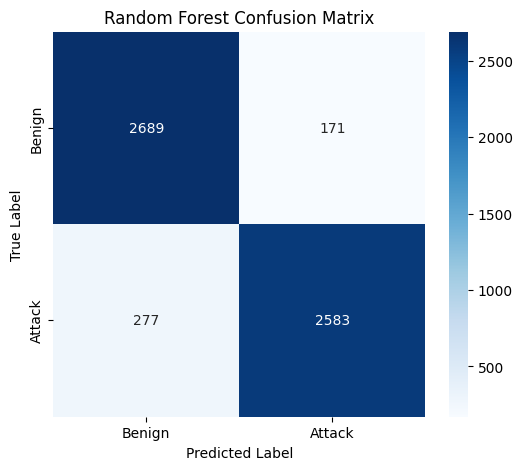


--- K-Nearest Neighbors ---
Accuracy: 0.9136
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      2860
           1       0.93      0.90      0.91      2860

    accuracy                           0.91      5720
   macro avg       0.91      0.91      0.91      5720
weighted avg       0.91      0.91      0.91      5720

Confusion Matrix:
[[2662  198]
 [ 296 2564]]


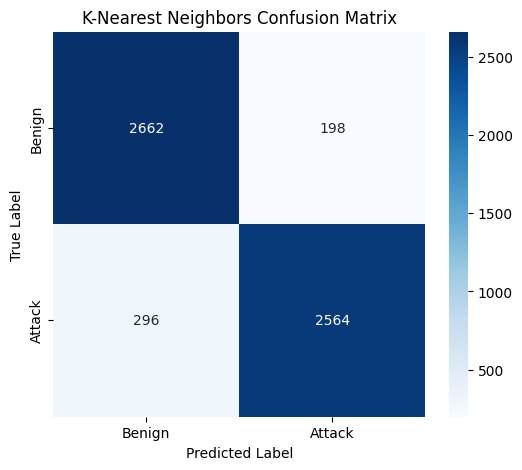


Model training and evaluation complete.

--- Summary of Results ---

Random Forest:
  Accuracy: 0.9217
  Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.94      0.92      2860
           1       0.94      0.90      0.92      2860

    accuracy                           0.92      5720
   macro avg       0.92      0.92      0.92      5720
weighted avg       0.92      0.92      0.92      5720

  Confusion Matrix:
 [[2689  171]
 [ 277 2583]]

K-Nearest Neighbors:
  Accuracy: 0.9136
  Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.93      0.92      2860
           1       0.93      0.90      0.91      2860

    accuracy                           0.91      5720
   macro avg       0.91      0.91      0.91      5720
weighted avg       0.91      0.91      0.91      5720

  Confusion Matrix:
 [[2662  198]
 [ 296 2564]]


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the models
random_forest = RandomForestClassifier(random_state=42)
knn = KNeighborsClassifier()

# Train and evaluate each model
models = {
    'Random Forest': random_forest,
    'K-Nearest Neighbors': knn
}

print("Training and evaluating models...")
results = {}
for name, model in models.items():
    print(f"\n--- {name} ---")
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        'accuracy': accuracy,
        'classification_report': report,
        'confusion_matrix': cm
    }

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(cm)

    # Visualize the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'{name} Confusion Matrix')
    plt.show()

print("\nModel training and evaluation complete.")
print("\n--- Summary of Results ---")
for name, result in results.items():
    print(f"\n{name}:")
    print(f"  Accuracy: {result['accuracy']:.4f}")
    print("  Classification Report:\n", result['classification_report'])
    print("  Confusion Matrix:\n", result['confusion_matrix'])

Epoch 1/25


/home/abderrazak.mahi/.conda/envs/project/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


572/572 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7807 - loss: 0.4763 - val_accuracy: 0.8813 - val_loss: 0.3040
Epoch 2/25
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8631 - loss: 0.3289 - val_accuracy: 0.8973 - val_loss: 0.2681
Epoch 3/25
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8687 - loss: 0.3172 - val_accuracy: 0.8772 - val_loss: 0.2993
Epoch 4/25
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8767 - loss: 0.3016 - val_accuracy: 0.9032 - val_loss: 0.2505
Epoch 5/25
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8799 - loss: 0.2936 - val_accuracy: 0.8971 - val_loss: 0.2650
Epoch 6/25
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8778 - loss: 0.2966 - val_accuracy: 0.9001 - val_loss: 0.2493
Epoch 7/25
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8813 - loss: 0.2847 - val_accuracy: 0.9006 - val_loss: 0.2518
Epoch 8/25
572/572 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8877 - loss: 0.2798 - val_accuracy: 0.9001 - val_

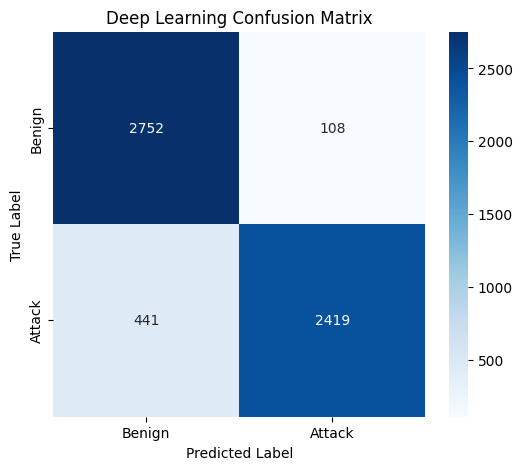

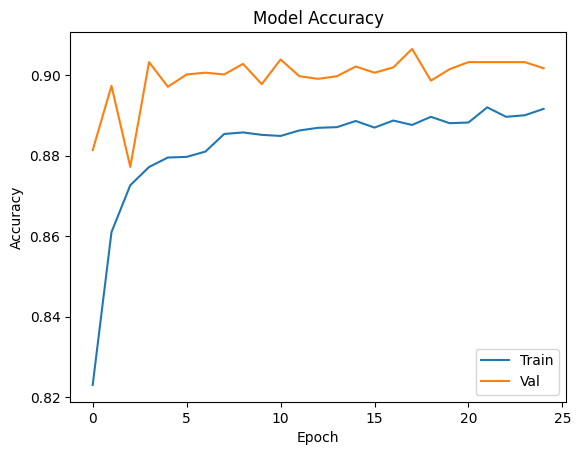

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Normalize data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 2. Build DL model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),

    Dense(1, activation='sigmoid')
])

# 3. Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# 4. Train
history = model.fit(X_train_scaled, y_train,
                    epochs=25,
                    batch_size=32,
                    validation_split=0.2,
                    verbose=1)

# 5. Predict
y_pred_probs = model.predict(X_test_scaled)
y_pred = (y_pred_probs > 0.5).astype("int32")

# 6. Evaluate
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)
print("Confusion Matrix:")
print(cm)

# 7. Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Deep Learning Confusion Matrix')
plt.show()

# 8. Accuracy curve
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()